In [67]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Definitions
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [68]:
# Get data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print('train:'+str(train.shape))
print('test:'+str(test.shape))
columns = train.columns
all_df = train.append(test, ignore_index = True)
all_df = all_df.ix[:,columns]
all_df.shape

train:(1460, 81)
test:(1459, 80)


(2919, 81)

In [69]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [70]:
# Check for Id duplicates
idsUnique = len(set(all_df.Id)) #set创建一个无序不重复序列
idsTotal = all_df.shape[0]
idsDupli = idsTotal - idsUnique
print('There are ' + str(idsDupli) + ' duplicate IDs for ' + str(idsTotal) 
      + ' total entries')

# Drop Id column
all_df.drop('Id', axis=1, inplace=True)

There are 0 duplicate IDs for 2919 total entries


In [71]:
# Data understanding
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


Skewness: 1.882876
Kurtosis: 6.536282


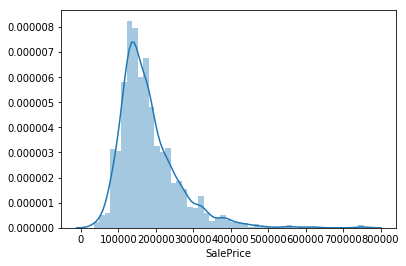

In [72]:
# Using histogram to have a big picture of the overall house price distribution
sns.distplot(train['SalePrice'])

# skewness and kurtosis 偏度和峰值
print('Skewness: %f' % train['SalePrice'].skew()) #偏度为正，说明数据集中在左边
print('Kurtosis: %f' % train['SalePrice'].kurt()) #峰值为0，说明正态分布

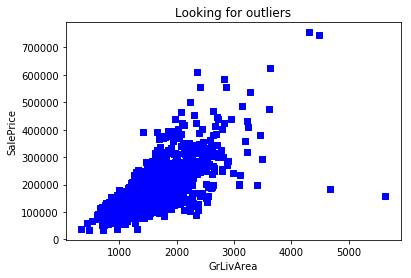

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298          60       RL        313.0    63887   Pave   NaN      IR3   
523           60       RL        130.0    40094   Pave   NaN      IR1   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
1298         Bnk    AllPub    Corner    ...          480     Gd   NaN   
523          Bnk    AllPub    Inside    ...            0    NaN   NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
1298         NaN       0      1    2008       New        Partial   160000.0  
523          NaN       0     10    2007       New        Partial   184750.0  

[2 rows x 80 columns]


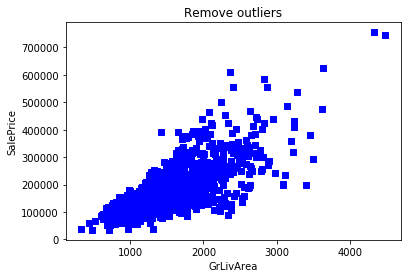

In [73]:
# Numerical features
# Scatter plot GrliveArea (Above grade (ground) living area square feet) and SalePrice
#all_df[0:1460] is train dataset
plt.scatter(all_df[0:1460]['GrLivArea'], all_df[0:1460]['SalePrice'], c='blue', marker='s')
plt.title('Looking for outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# Deleting points
#print(all_df[0:1460].sort_values(by='GrLivArea', ascending=False).head()[0:2]) 
all_df = all_df.drop(523)
all_df = all_df.drop(1298)

# Scatter plot for removing outliers
plt.scatter(all_df[0:1458]['GrLivArea'], all_df[0:1458]['SalePrice'], c='blue', marker='s')
plt.title('Remove outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [75]:
# log transform the target for official scoring
# 在数据预处理的时候可以对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布
# 此步处理可能会对我们后续的分类得到一个更好的结果
# log1p 即 ln(x+1)
all_df[0:1458].SalePrice = np.log1p(all_df[0:1458].SalePrice)
y = all_df[0:1458].SalePrice
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [89]:
all_df.iloc[]

KeyError: 'the label [1298] is not in the [index]'

In [236]:
train_desc = pd.DataFrame(train.describe().T)
train_desc
train_desc.loc[train_desc['count']!=1458]

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1199.000,69.797,23.203,21.000,59.000,69.000,80.000,313.000
MasVnrArea,1450.000,102.754,179.442,0.000,0.000,0.000,164.750,1600.000
GarageYrBlt,1377.000,1978.464,24.683,1900.000,1961.000,1980.000,2002.000,2010.000


In [237]:
# check Alley NA total qty and fill NA with 'None', means 'no alley access'
train[train.loc[:,'Alley'].isnull()].shape
train.loc[:,'Alley'] = train.loc[:,'Alley'].fillna('None')
# fill NA with 'No', means 'no basement'
train.loc[:,'BsmtQual'] = train.loc[:,'BsmtQual'].fillna('No')
train.loc[:,'BsmtCond'] = train.loc[:,'BsmtCond'].fillna('No')
train.loc[:,'BsmtExposure'] = train.loc[:,'BsmtExposure'].fillna('No')
train.loc[:,'BsmtFinType1'] = train.loc[:,'BsmtFinType1'].fillna('No')
train.loc[:,'BsmtFinType2'] = train.loc[:,'BsmtFinType1'].fillna('No')
# fill NA with 'No', means 'no fence'
train.loc[:,'Fence'] = train.loc[:,'Fence'].fillna('No')
# fill NA with 'No', means 'no fireplace'
train.loc[:,'FireplaceQu'] = train.loc[:'FireplaceQu'].fillna('No')
# fill NA with 'No', means 'no garage'
train.loc[:,'GarageType'] = train.loc[:,'GarageType'].fillna('No')
train.loc[:,'GarageFinish'] = train.loc[:,'GarageFinish'].fillna('No')
train.loc[:,'GarageQual'] = train.loc[:,'GarageQual'].fillna('No')
train.loc[:,'GarageCond'] = train.loc[:,'GarageCond'].fillna('No')
# fill NA with 0, means 'no log frontage'
train.loc[:,'LotFrontage'] = train.loc[:,'LotFrontage'].fillna(0)
# fill NA with 'None', means 'no venner'
train.loc[:,'MasVnrType'] = train.loc[:,'MasVnrType'].fillna('None')
train.loc[:,'MasVnrArea'] = train.loc[:,'MasVnrArea'].fillna(0)
# fill NA with 'No', means 'no misc feature'
train.loc[:,'MiscFeature'] = train.loc[:,'MiscFeature'].fillna('No')
# fill NA with 'No', means 'no pool'
train.loc[:,'PoolQC'] = train.loc[:,'PoolQC'].fillna('No')


#train[train.loc[:,'WoodDeckSF'].isnull()].shape  #use this code to check each column's 'NAN' qty

In [238]:
# Some numerical features are actually really categories
train = train.replace({'MSSubClass':{20:'SC20',30:'SC30',40:'SC40',45:'SC45',
                                    50:'SC50',60:'SC60',70:'SC70',80:'SC80',
                                    85:'SC85',90:'SC90',120:'SC120',150:'SC150',
                                    180:'SC180',190:'SC190'},
                      'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                               6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                               11:'Nov',12:'Dec'}})


In [239]:
# Encode some categorial features as ordered numbers when there is information 
# in the order
train = train.replace({'Alley':{'Grvl':1,'Pave':2},
                      'BsmtQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'BsmtCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'BsmtExposure':{'No':0,'Mn':1,'Av':2,'Gd':3},
                      'BsmtFinType1':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                      'BsmtFinType2':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                      'ExterQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'ExterCond':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'FireplaceQu':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,
                                   'Min2':6,'Min1':7,'Typ':8},
                      'GarageCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'GarageQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'HeatingQC':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'KitchenQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
                      'LotShape':{'IR3':1,'IR2':2,'IR3':1,'Reg':4},
                       'PavedDrive':{'N':0,'P':1,'Y':2},
                       'PoolQC':{'No':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
                       'Street':{'Grvl':0,'Pave':2},
                       'Utilities':{'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub':4},
                      })

In [240]:
# Create new features
# 1. Simplifications of existing features
train['SimplOverallQual'] = train['OverallQual'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
train['SimplOverallCond'] = train['OverallCond'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
train['SimplPoolQC'] = train['PoolQC'].replace({1:1,2:1, #ave
                                                3:2,4:2 #good
                                               })
train['SimplGarageCond'] = train['GarageCond'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
train['SimplGarageQual'] = train['GarageQual'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
train['SimplFireplaceQu'] = train['FireplaceQu'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
train['SimplFunctional'] = train['Functional'].replace({1:1,2:1, #bad
                                                      3:2,4:2, #major
                                                      5:3,6:3,7:3, #minor
                                                      8:4 #typlical
                                                     })
train['SimplKitchenQual'] = train['KitchenQual'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
train['SimplHeatingQC'] = train['HeatingQC'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
train['SimplBsmtFinType1'] = train['BsmtFinType1'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
train['SimplBsmtFinType2'] = train['BsmtFinType2'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
train['SimplBsmtCond'] = train['BsmtCond'].replace({1:1, #bad
                                                  2:1,3:1, #ave
                                                  4:2,5:2 #good
                                                 })
train['SimplBsmtQual'] = train['BsmtQual'].replace({1:1, #bad
                                                    2:1,3:1, #ave
                                                    4:2, 5:2 #good
                                                   })
train['SimplExterCond'] = train['ExterCond'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
train['SimplExterQual'] = train['ExterQual'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
                                                
            

In [241]:
# 2. Combinations of existing features
# Overall quality of the house
train['OverallGrade'] = train['OverallQual'] * train['OverallCond']
# Overall quality of the garage
train['GarageGrade'] = train['GarageQual'] * train['GarageCond']
# Overall quality of the exterior
train['ExterGrade'] = train['ExterQual'] * train['ExterCond']
# Overall kitchen score
train['KitchenScore'] = train['KitchenAbvGr'] * train['KitchenQual']
# Overall fireplace score
train['FireplaceScore'] = train['Fireplaces'] * train['FireplaceQu']
# Overall garage score
train['GarageScore'] = train['GarageArea'] * train['GarageQual']
# Overall pool score
train['PoolScore'] = train['PoolArea'] * train['PoolQC']

# Simplified overall quality of the house
train['SimplOverallGrade'] = train['SimplOverallQual'] * train['SimplOverallCond']
# Simplified overall quality of the exterior
train['SimplExterGrade'] = train['SimplExterQual'] * train['SimplExterCond']
# Simplified overall pool score
train['SimplPoolScore'] = train['PoolArea'] * train['SimplPoolQC']
# Simplified overall garage score
train['SimplGarageScore'] = train['GarageArea'] * train['SimplGarageQual']
# Simplified overall fireplace score
train['SimplFireplaceScore'] = train['Fireplaces'] * train['SimplFireplaceQu']
# Simplified overall kitchen score
train['SimplKitchenScore'] = train['KitchenAbvGr'] * train['SimplKitchenQual']
# Total number of bathrooms
train['TotalBath'] = train['BsmtFullBath'] + (0.5*train['BsmtHalfBath']) +\
                     train['FullBath'] + (0.5*train['HalfBath'])
# Total SF for house (include basement)
train['AllSF'] = train['GrLivArea'] + train['TotalBsmtSF']
# Total SF for 1st+2nd floors
train['AllFlrsSF'] = train['1stFlrSF'] + train['2ndFlrSF']
# Total SF for porch
train['AllPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] +\
                      train['3SsnPorch'] + train['ScreenPorch']
# Has masonry veneer or not
train['HasMasVnr'] = train['MasVnrType'].replace({'BrkCmn':1,'BrkFace':1,'CBlock':1,
                                                  'Stone':1,'None':0})
# House completed before sale or not
train['BoughtOffPlan'] = train['SaleCondition'].replace({'Abnorml':0,'Alloca':0,
                                                         'AdjLand':0,'Family':0,
                                                         'Normal':0,'Partial':1})


In [242]:
# Find most important features relative to target
print('Find most important features relative to target')
corr = train.corr()
corr.sort_values(['SalePrice'],ascending=False,inplace=True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.821
AllSF                0.821
AllFlrsSF            0.735
GrLivArea            0.725
SimplOverallQual     0.707
ExterQual            0.682
GarageCars           0.681
TotalBath            0.677
KitchenQual          0.670
GarageScore          0.658
GarageArea           0.656
TotalBsmtSF          0.648
SimplExterQual       0.635
SimplGarageScore     0.631
1stFlrSF             0.621
BsmtQual             0.617
SimplKitchenQual     0.609
OverallGrade         0.608
FullBath             0.596
SimplBsmtQual        0.592
ExterGrade           0.588
YearBuilt            0.587
YearRemodAdd         0.566
FireplaceQu          0.547
GarageYrBlt          0.542
TotRmsAbvGrd         0.538
SimplOverallGrade    0.525
FireplaceScore       0.524
SimplKitchenScore    0.523
                     ...  
LotArea              0.261
BsmtFullBath         0.237
BsmtUnfSF            0.222
BedroomAbvGr         0.209
SimplBs

In [243]:
# Create new features
# 3. Polynomials on the top10 existing features
train['OverallQual-s2'] = train['OverallQual']**2
train['OverallQual-s3'] = train['OverallQual']**3
train['OverallQual-Sq'] = np.sqrt(train['OverallQual'])
train['AllSF-2'] = train['AllSF']**2
train['AllSF-3'] = train['AllSF']**3
train['AllSF-Sq'] = np.sqrt(train['AllSF'])
train['AllFlrsSF-2'] = train['AllFlrsSF']**2
train['AllFlrsSF-3'] = train['AllFlrsSF']**3
train['AllFlrsSF-Sq'] = np.sqrt(train['AllFlrsSF'])
train['GrLivArea-2'] = train['GrLivArea']**2
train['GrLivArea-3'] = train['GrLivArea']**3
train['GrLivArea-Sq'] = np.sqrt(train['GrLivArea'])
train['SimplOverallQual-s2'] = train['SimplOverallQual']**2
train['SimplOverallQual-s3'] = train['SimplOverallQual']**3
train['SimplOverallQual-Sq'] = np.sqrt(train['SimplOverallQual'])
train['ExterQual-2'] = train['ExterQual']**2
train['ExterQual-3'] = train['ExterQual']**3
train['ExterQual-Sq'] = np.sqrt(train['ExterQual'])
train['GarageCars-2'] = train['GarageCars']**2
train['GarageCars-3'] = train['GarageCars']**3
train['GarageCars-Sq'] = np.sqrt(train['GarageCars'])
train['TotalBath-2'] = train['TotalBath']**2
train['TotalBath-3'] = train['TotalBath']**3
train['TotalBath-Sq'] = np.sqrt(train['TotalBath'])
train['KitchenQual-2'] = train['KitchenQual']**2
train['KitchenQual-3'] = train['KitchenQual']**3
train['KitchenQual-Sq'] = np.sqrt(train['KitchenQual'])
train['GarageScore-2'] = train['GarageScore']**2
train['GarageScore-3'] = train['GarageScore']**3
train['GarageScore-Sq'] = np.sqrt(train['GarageScore'])

In [244]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(exclude=['object']).columns
numerical_features = numerical_features.drop('SalePrice')

print('Numerical features:'+ str(len(numerical_features)))
print('Categorical features:'+ str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features:116
Categorical features:27


In [245]:
# Handle remaining missing values for numerical features by using median 
# as replacement
print('NAs for numerical features in train: '+str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print('Remaining NAs for numerical features in train: '+str(train_num.isnull().values.sum()))

NAs for numerical features in train: 81
Remaining NAs for numerical features in train: 0


In [246]:
# log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value >0.5 is
# considered at least moderately skewed
# log1p(x) = ln(x)
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness)>0.5]
print(str(skewness.shape[0]) + ' skewed numerical features to log transform')
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


In [247]:
# train_num after skewed
train_num[skewed_features].head()

,LotArea,Street,Utilities,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,GarageCars-2,GarageCars-3,GarageCars-Sq,TotalBath-2,TotalBath-3,KitchenQual-2,KitchenQual-3,GarageScore-2,GarageScore-3,GarageScore-Sq
0,9.042,1.099,1.609,1.386,1.792,7.603,7.603,5.283,1.609,1.386,...,1.609,2.197,0.881,2.584,3.781,2.833,4.174,14.810,22.215,3.727
1,9.170,1.099,1.609,1.386,2.197,7.589,7.589,0.000,1.386,1.386,...,1.609,2.197,0.881,1.981,2.811,2.303,3.332,14.460,21.690,3.641
2,9.328,1.099,1.609,1.386,1.792,7.602,7.602,5.094,1.609,1.386,...,1.609,2.197,0.881,2.584,3.781,2.833,4.174,15.018,22.526,3.778
3,9.164,1.099,1.609,1.386,1.792,7.558,7.586,0.000,1.386,1.386,...,2.303,3.332,1.005,1.609,2.197,2.833,4.174,15.126,22.690,3.804
4,9.565,1.099,1.609,1.386,1.792,7.601,7.601,5.861,1.609,1.386,...,2.303,3.332,1.005,2.584,3.781,2.833,4.174,15.654,23.482,3.933


In [248]:
# Create dummy features for categarical values via one-hot encoding
print('NAs for categorical features in train: '+\
      str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print('Remaining NAs for categorical features in train: '+\
      str(train_cat.isnull().values.sum()))

NAs for categorical features in train: 1
Remaining NAs for categorical features in train: 0


In [249]:
# Join numerical and categorical features
train = pd.concat([train_num, train_cat], axis=1)
print('New number of features: ' + str(train.shape[1]))

# Partition the dataset in train + validation sets
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, 
                                                    random_state=0)
print('x_train: ' + str(x_train.shape))
print('x_test: ' + str(x_test.shape))
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

New number of features: 322
x_train: (1020, 322)
x_test: (438, 322)
y_train: (1020,)
y_test: (438,)


In [250]:
# Standardize numerical features
stdSc = StandardScaler()
x_train.loc[:,numerical_features] = stdSc.fit_transform(x_train.loc[:,numerical_features])
x_test.loc[:,numerical_features] = stdSc.transform(x_test.loc[:,numerical_features])

In [251]:
# Define error measure for official scoring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    # 这里的scores都是负数，为什么均方误差会出现负数的情况呢？
    # 由于这里的mean_squared_error是一种损失函数，优化的目标的使其最小化。
    # 而分类准确率是一种奖励函数，优化的目标是使其最大化。
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring=scorer, cv=10))
    return(rmse)

def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test, scoring=scorer, cv=10))
    return(rmse)

RMSE on Training set:  24248881158.36106
RMSE on Test set:  55161335043.809425


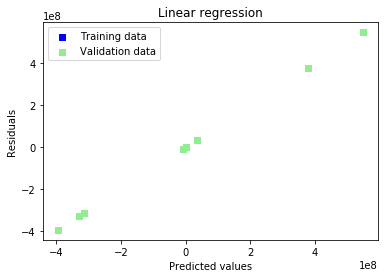

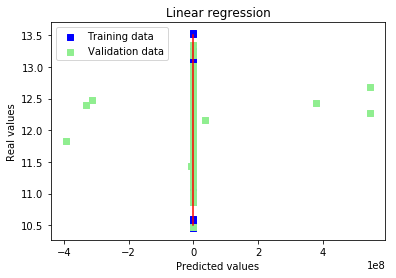

In [252]:
# Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train) 
# Look at predictions on training and validation set
print('RMSE on Training set: ', rmse_cv_train(lr).mean())
print('RMSE on Test set: ', rmse_cv_test(lr).mean())
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
# Plot residuals
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-5, xmax=13, color='red')
plt.show()
# Plot predictions
plt.scatter(y_train_pred, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_pred, y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='upper left')
plt.plot([10.5, 13.5],[10.5,13.5], c='red')
plt.show()

Best alpha:  30.0
Try again for more precision with alphas centerd around 30.0
Best alpha:  22.5
Ridge RMSE on Training set:  0.11306161624932753
Ridge RMSE on Test set:  0.12128738486453779


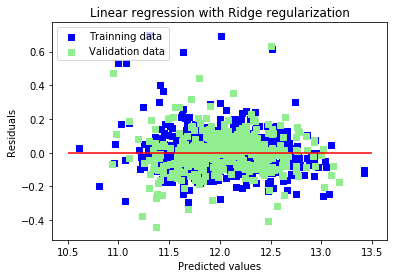

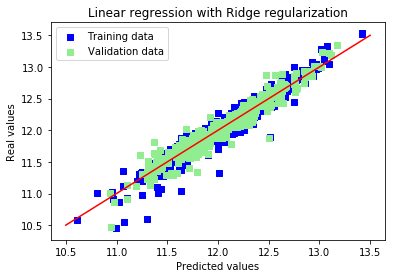

Ridge picked 316 features and eliminated the other 6 features 


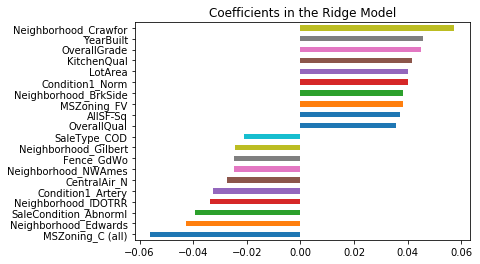

In [253]:
# 2. Linear regression with Ridge regularization (L2 Penalty)
ridge = RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10 ,30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print('Best alpha: ', alpha)
print('Try again for more precision with alphas centerd around '+str(alpha))
ridge = RidgeCV(alphas=[alpha*0.6, alpha*0.65, alpha*0.7, alpha*0.75, alpha*0.8,
                        alpha*0.85, alpha*0.9, alpha*1.05, alpha*1.1, alpha*1.15,
                        alpha*1.2, alpha*1.25, alpha*1.3, alpha*1.35, alpha*1.4])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print('Best alpha: ', alpha)

print('Ridge RMSE on Training set: ', rmse_cv_train(ridge).mean())
print('Ridge RMSE on Test set: ', rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(x_train)
y_test_rdg = ridge.predict(x_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg-y_train, c='blue', marker='s', label='Trainning data')
plt.scatter(y_test_rdg, y_test_rdg-y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with Ridge regularization')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=10.5, xmax=13.5, color='red')
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_rdg, y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with Ridge regularization')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='upper left')
plt.plot([10.5,13.5],[10.5,13.5],c='red')
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print('Ridge picked ' + str(sum(coefs !=0)) + ' features and eliminated the other '+\
      str(sum(coefs==0)) + ' features ')
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind='barh')
plt.title('Coefficients in the Ridge Model')
plt.show()

Best alpha：  0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha:  0.00078
Lasso RMSE on Training set:  0.11242887472119549
Lasso RMSE on Test set:  0.11928176246172499


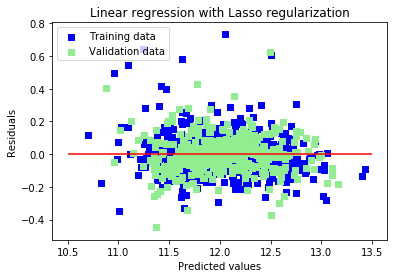

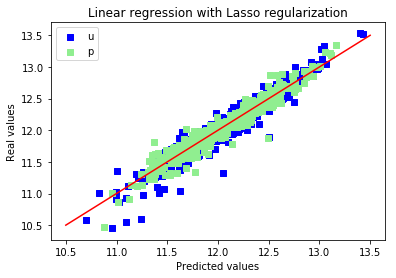

Lasso picked 97 features and eliminated the other 225 features


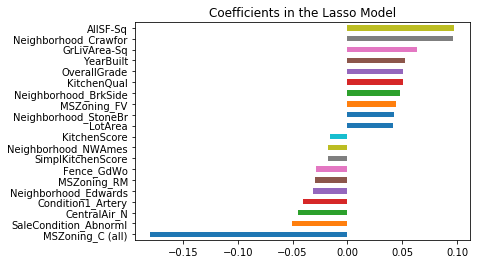

In [254]:
# 3. Linear regression with LASSO regularization (L1 Penalty)
lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                        0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter=50000, cv=10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print('Best alpha： ', alpha)
print('Try again for more precision with alphas centered around '+str(alpha))
lasso = LassoCV(alphas=[alpha*0.6, alpha*0.65, alpha*0.7, alpha*0.75, alpha*0.8,
                        alpha*0.85, alpha*0.9, alpha*0.95, alpha*1.05, alpha*1.1,
                        alpha*1.15, alpha*1.2, alpha*1.25, alpha*1.3, alpha*1.35,
                        alpha*1.4], max_iter=50000, cv=10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print('Best alpha: ', alpha)

print('Lasso RMSE on Training set: ', rmse_cv_train(lasso).mean())
print('Lasso RMSE on Test set: ', rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(x_train)
y_test_las = lasso.predict(x_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las-y_train, c='blue', marker='s', 
            label='Training data')
plt.scatter(y_test_las, y_test_las-y_test, c='lightgreen', marker='s',
            label='Validation data')
plt.title('Linear regression with Lasso regularization')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=10.5, xmax=13.5, color='red')
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_las, y_test, c='lightgreen', marker='s', label='Valication data')
plt.title('Linear regression with Lasso regularization')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend('upper left')
plt.plot([10.5,13.5], [10.5,13.5], c='red')
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index=x_train.columns)
print('Lasso picked '+str(sum(coefs!=0))+' features and eliminated the other '+\
      str(sum(coefs==0))+' features')
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')
plt.show()

Best l1_ratio:  0.8
Best alpha:  0.001
Try again for more precision with l1_ratio center around: 0.8
Best l1_ratio:  0.76
Best alpha:  0.001
Now try again for more precision with alpha, with l1_ratio fixed at 0.76 and alpha centered around 0.001
Best L1_ratio:  0.76
Best alpha:  0.0010500000000000002
ElasticNet RMSE on Training set:  0.11191894967629215
ElasticNet RMSE on Test set:  0.1193218790252393


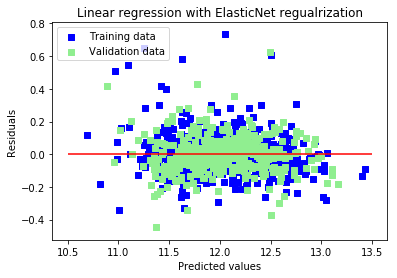

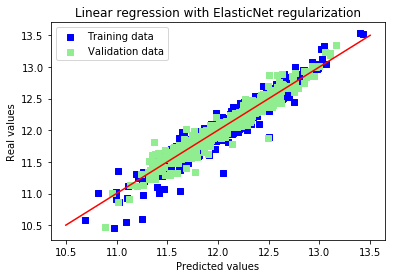

ElasticNet picked 97 features and eliminiated the other 225 features


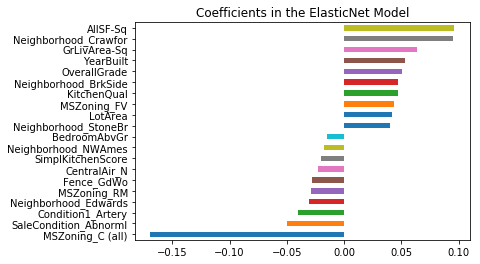

In [259]:
# 4. Linear Regression with ElasticNet regularization (L1 and L2 penalty)
elasticNet = ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.6,0.7,0.8,0.85,0.9,0.95,1],
                          alphas=[0.0001,0.0003,0.0006,0.001,0.003,0.006,
                                  0.01,0.03,0.06,0.1,0.3,0.6,1,3,6],
                          max_iter=50000, cv=10)
elasticNet.fit(x_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best l1_ratio: ', ratio)
print('Best alpha: ', alpha)

print('Try again for more precision with l1_ratio center around: '+str(ratio))
elasticNet = ElasticNetCV(l1_ratio=[ratio*0.85, ratio*0.9, ratio*0.95, 
                                    ratio*1.05, ratio*1.1, ratio*1.15],
                          alphas = [0.0001,0.0003,0.0006,0.001,0.003,0.006,
                                  0.01,0.03,0.06,0.1,0.3,0.6,1,3,6],
                          max_iter=50000, cv=10)
elasticNet.fit(x_train,y_train)
if (elasticNet.l1_ratio_>1):
    elasticNet.l1_ratio=1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best l1_ratio: ',ratio)
print('Best alpha: ',alpha)

print('Now try again for more precision with alpha, with l1_ratio fixed at '+\
      str(ratio)+' and alpha centered around '+str(alpha))
elasticNet = ElasticNetCV(l1_ratio=ratio, alphas=[alpha*0.6, alpha*0.65, alpha*0.7,
                                                  alpha*0.75,alpha*0.8, alpha*0.85, 
                                                  alpha*0.9, alpha*0.95, alpha*1.05, 
                                                  alpha*1.1, alpha*1.15, alpha*1.2,
                                                  alpha*1.25, alpha*1.3, alpha*1.35, 
                                                  alpha*1.4], max_iter=50000, cv=10)
elasticNet.fit(x_train, y_train)
if (elasticNet.l1_ratio_>1):
    elasticNet.l1_ratio=1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best L1_ratio: ', ratio)
print('Best alpha: ', alpha)

print('ElasticNet RMSE on Training set: ', rmse_cv_train(elasticNet).mean())
print('ElasticNet RMSE on Test set: ', rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(x_train)
y_test_ela = elasticNet.predict(x_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela-y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_ela, y_test_ela-y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with ElasticNet regualrization')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=10.5, xmax=13.5, color='red')
plt.show()

# Plot predictions
plt.scatter(y_train_ela, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_ela, y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with ElasticNet regularization')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='upper left')
plt.plot([10.5,13.5],[10.5,13.5],c='red')
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index=x_train.columns)
print('ElasticNet picked '+str(sum(coefs!=0))+' features and eliminiated the other '+\
       str(sum(coefs==0))+' features')
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind='barh')
plt.title('Coefficients in the ElasticNet Model')
plt.show()

In [267]:
test = pd.read_csv('./test.csv')
test.drop('Id',axis=1,inplace=True)
# check Alley NA total qty and fill NA with 'None', means 'no alley access'
test[test.loc[:,'Alley'].isnull()].shape
test.loc[:,'Alley'] = test.loc[:,'Alley'].fillna('None')
# fill NA with 'No', means 'no basement'
test.loc[:,'BsmtQual'] = test.loc[:,'BsmtQual'].fillna('No')
test.loc[:,'BsmtCond'] = test.loc[:,'BsmtCond'].fillna('No')
test.loc[:,'BsmtExposure'] = test.loc[:,'BsmtExposure'].fillna('No')
test.loc[:,'BsmtFinType1'] = test.loc[:,'BsmtFinType1'].fillna('No')
test.loc[:,'BsmtFinType2'] = test.loc[:,'BsmtFinType1'].fillna('No')
# fill NA with 'No', means 'no Exterior1st'
test.loc[:,'Exterior1st'] = test.loc[:,'Exterior1st'].fillna('No')
# fill NA with 'No', means 'no Exterior2nd'
test.loc[:,'Exterior2nd'] = test.loc[:,'Exterior2nd'].fillna('No')
# fill NA with 'No', means 'no fence'
test.loc[:,'Fence'] = test.loc[:,'Fence'].fillna('No')
# fill NA with 'No', means 'no fireplace'
test.loc[:,'FireplaceQu'] = test.loc[:,'FireplaceQu'].fillna('No')
# fill NA with 'Typ', means typical
test.loc[:,'Functional'] = test.loc[:,'Functional'].fillna('Typ')
# fill NA with 'No', means 'no garage'
test.loc[:,'GarageType'] = test.loc[:,'GarageType'].fillna('No')
test.loc[:,'GarageFinish'] = test.loc[:,'GarageFinish'].fillna('No')
test.loc[:,'GarageQual'] = test.loc[:,'GarageQual'].fillna('No')
test.loc[:,'GarageCond'] = test.loc[:,'GarageCond'].fillna('No')
test.loc[:,'GarageArea'] = test.loc[:,'GarageArea'].fillna(0)
test.loc[:,'GarageCars'] = test.loc[:,'GarageCars'].fillna(0)
# fill NA with 'TA', NA most likely means typical
test.loc[:,'KitchenQual'] = test.loc[:,'KitchenQual'].fillna('TA')
# fill NA with 0, means 'no log frontage'
train.loc[:,'LotFrontage'] = test.loc[:,'LotFrontage'].fillna(0)
# fill NA with 'None', means 'no venner'
test.loc[:,'MasVnrType'] = test.loc[:,'MasVnrType'].fillna('None')
test.loc[:,'MasVnrArea'] = test.loc[:,'MasVnrArea'].fillna(0)
# fill NA with 'No', means 'no misc feature'
test.loc[:,'MiscFeature'] = test.loc[:,'MiscFeature'].fillna('No')
# fill NA with 'No', means 'no MSZoning'
test.loc[:,'MSZoning'] = test.loc[:,'MSZoning'].fillna('No')
# fill NA with 'No', means 'no pool'
test.loc[:,'PoolQC'] = test.loc[:,'PoolQC'].fillna('No')
test.loc[:,'Utilities'] = test.loc[:,'Utilities'].fillna('No')

#test[test.loc[:,'GarageArea'].isnull()] #use this code to check each column's 'NAN' qty

# Some numerical features are actually really categories
test = test.replace({'MSSubClass':{20:'SC20',30:'SC30',40:'SC40',45:'SC45',
                                    50:'SC50',60:'SC60',70:'SC70',80:'SC80',
                                    85:'SC85',90:'SC90',120:'SC120',150:'SC150',
                                    180:'SC180',190:'SC190'},
                      'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                               6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                               11:'Nov',12:'Dec'}})

# Encode some categorial features as ordered numbers when there is information 
# in the order
test = test.replace({'Alley':{'None':0,'Grvl':1,'Pave':2},
                     'BsmtCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}, 
                     'BsmtQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'BsmtExposure':{'No':0,'Mn':1,'Av':2,'Gd':3},
                     'BsmtFinType1':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                     'BsmtFinType2':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                     'ExterQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'ExterCond':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'FireplaceQu':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,
                                   'Min2':6,'Min1':7,'Typ':8},
                     'GarageCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'GarageQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'HeatingQC':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'KitchenQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                     'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
                     'LotShape':{'IR3':1,'IR2':2,'IR3':1,'Reg':4},
                     'PavedDrive':{'N':0,'P':1,'Y':2},
                     'PoolQC':{'No':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
                     'Street':{'Grvl':0,'Pave':2},
                     'Utilities':{'No':0,'AllPub':4}
                    })

# Data preprocess for final test data
test_categorical_features = test.select_dtypes(include=['object']).columns
test_numerical_features = test.select_dtypes(exclude=['object']).columns
print('Numerical features: '+str(len(test_numerical_features)))
print('Categorical features: '+str(len(test_categorical_features)))
test_num = test[test_numerical_features]
test_cat = test[test_categorical_features]

# Create new features
# 1. Simplifications of existing features
test['SimplOverallQual'] = test['OverallQual'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
test['SimplOverallCond'] = test['OverallCond'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
test['SimplPoolQC'] = test['PoolQC'].replace({1:1,2:1, #ave
                                                3:2,4:2 #good
                                               })
test['SimplGarageCond'] = test['GarageCond'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
test['SimplGarageQual'] = test['GarageQual'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
test['SimplFireplaceQu'] = test['FireplaceQu'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
test['SimplFunctional'] = test['Functional'].replace({1:1,2:1, #bad
                                                      3:2,4:2, #major
                                                      5:3,6:3,7:3, #minor
                                                      8:4 #typlical
                                                     })
test['SimplKitchenQual'] = test['KitchenQual'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
test['SimplHeatingQC'] = test['HeatingQC'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
test['SimplBsmtFinType1'] = test['BsmtFinType1'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
test['SimplBsmtFinType2'] = test['BsmtFinType2'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
test['SimplBsmtCond'] = test['BsmtCond'].replace({1:1, #bad
                                                  2:1,3:1, #ave
                                                  4:2,5:2 #good
                                                 })
test['SimplBsmtQual'] = test['BsmtQual'].replace({1:1, #bad
                                                    2:1,3:1, #ave
                                                    4:2, 5:2 #good
                                                   })
test['SimplExterCond'] = test['ExterCond'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
test['SimplExterQual'] = test['ExterQual'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })

# 2. Combinations of existing features
# Overall quality of the house
test['OverallGrade'] = test['OverallQual'] * test['OverallCond']
# Overall quality of the garage
test['GarageGrade'] = test['GarageQual'] * test['GarageCond']
# Overall quality of the test
test['ExterGrade'] = test['ExterQual'] * test['ExterCond']
# Overall kitchen score
test['KitchenScore'] = test['KitchenAbvGr'] * test['KitchenQual']
# Overall fireplace score
test['FireplaceScore'] = test['Fireplaces'] * test['FireplaceQu']
# Overall garage score
test['GarageScore'] = test['GarageArea'] * test['GarageQual']
# Overall pool score
test['PoolScore'] = test['PoolArea'] * test['PoolQC']

# Simplified overall quality of the house
test['SimplOverallGrade'] = test['SimplOverallQual'] * test['SimplOverallCond']
# Simplified overall quality of the exterior
test['SimplExterGrade'] = test['SimplExterQual'] * test['SimplExterCond']
# Simplified overall pool score
test['SimplPoolScore'] = test['PoolArea'] * test['SimplPoolQC']
# Simplified overall garage score
test['SimplGarageScore'] = test['GarageArea'] * test['SimplGarageQual']
# Simplified overall fireplace score
test['SimplFireplaceScore'] = test['Fireplaces'] * test['SimplFireplaceQu']
# Simplified overall kitchen score
test['SimplKitchenScore'] = test['KitchenAbvGr'] * test['SimplKitchenQual']
# Total number of bathrooms
test['TotalBath'] = test['BsmtFullBath'] + (0.5*test['BsmtHalfBath']) +\
                     test['FullBath'] + (0.5*test['HalfBath'])
# Total SF for house (include basement)
test['AllSF'] = test['GrLivArea'] + test['TotalBsmtSF']
# Total SF for 1st+2nd floors
test['AllFlrsSF'] = test['1stFlrSF'] + test['2ndFlrSF']
# Total SF for porch
test['AllPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] +\
                      test['3SsnPorch'] + test['ScreenPorch']
# Has masonry veneer or not
test['HasMasVnr'] = test['MasVnrType'].replace({'BrkCmn':1,'BrkFace':1,'CBlock':1,
                                                  'Stone':1,'None':0})
# House completed before sale or not
test['BoughtOffPlan'] = test['SaleCondition'].replace({'Abnorml':0,'Alloca':0,
                                                         'AdjLand':0,'Family':0,
                                                         'Normal':0,'Partial':1})

# Create new features
# 3. Polynomials on the top10 existing features
test['OverallQual-s2'] = test['OverallQual']**2
test['OverallQual-s3'] = test['OverallQual']**3
test['OverallQual-Sq'] = np.sqrt(test['OverallQual'])
test['AllSF-2'] = test['AllSF']**2
test['AllSF-3'] = test['AllSF']**3
test['AllSF-Sq'] = np.sqrt(test['AllSF'])
test['AllFlrsSF-2'] = test['AllFlrsSF']**2
test['AllFlrsSF-3'] = test['AllFlrsSF']**3
test['AllFlrsSF-Sq'] = np.sqrt(test['AllFlrsSF'])
test['GrLivArea-2'] = test['GrLivArea']**2
test['GrLivArea-3'] = test['GrLivArea']**3
test['GrLivArea-Sq'] = np.sqrt(test['GrLivArea'])
test['SimplOverallQual-s2'] = test['SimplOverallQual']**2
test['SimplOverallQual-s3'] = test['SimplOverallQual']**3
test['SimplOverallQual-Sq'] = np.sqrt(test['SimplOverallQual'])
test['ExterQual-2'] = test['ExterQual']**2
test['ExterQual-3'] = test['ExterQual']**3
test['ExterQual-Sq'] = np.sqrt(test['ExterQual'])
test['GarageCars-2'] = test['GarageCars']**2
test['GarageCars-3'] = test['GarageCars']**3
test['GarageCars-Sq'] = np.sqrt(test['GarageCars'])
test['TotalBath-2'] = test['TotalBath']**2
test['TotalBath-3'] = test['TotalBath']**3
test['TotalBath-Sq'] = np.sqrt(test['TotalBath'])
test['KitchenQual-2'] = test['KitchenQual']**2
test['KitchenQual-3'] = test['KitchenQual']**3
test['KitchenQual-Sq'] = np.sqrt(test['KitchenQual'])
test['GarageScore-2'] = test['GarageScore']**2
test['GarageScore-3'] = test['GarageScore']**3
test['GarageScore-Sq'] = np.sqrt(test['GarageScore'])

# Differentiate numerical features (minus the target) and categorical features
categorical_features = test.select_dtypes(include=['object']).columns
numerical_features = test.select_dtypes(exclude=['object']).columns
print('Numerical features:'+ str(len(numerical_features)))
print('Categorical features:'+ str(len(categorical_features)))
test_num = test[numerical_features]
test_cat = test[categorical_features]

# Handle remaining missing values for numerical features by using median 
# as replacement
print('NAs for numerical features in test: '+str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print('Remaining NAs for numerical features in test: '+str(test_num.isnull().values.sum()))

# Create dummy features for categarical values via one-hot encoding
print('NAs for categorical features in test: '+\
      str(test_cat.isnull().values.sum()))
test_cat = pd.get_dummies(test_cat)
print('Remaining NAs for categorical features in test: '+\
      str(test_cat.isnull().values.sum()))

Numerical features: 53
Categorical features: 26
Numerical features:117
Categorical features:26
NAs for numerical features in test: 325
Remaining NAs for numerical features in test: 0
NAs for categorical features in test: 1
Remaining NAs for categorical features in test: 0


In [270]:
x_test.head()

,LotFrontage,LotArea,Street,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
411,1.241,2.709,0.063,0.031,0.218,-0.816,-0.441,-0.494,-1.438,-0.784,...,0,0,0,1,0,0,0,0,1,0
211,0.739,0.264,0.063,0.031,0.218,-0.070,-0.441,1.237,1.170,-0.784,...,0,0,0,1,0,0,0,0,1,0
342,-1.712,-0.140,0.063,0.031,0.218,-2.307,-1.513,-0.689,-1.683,1.469,...,0,0,0,1,0,0,0,0,1,0
303,0.355,0.139,0.063,0.031,0.218,-0.816,1.252,0.056,-0.609,-0.784,...,0,0,0,1,1,0,0,0,0,0
159,2.245,1.526,0.063,0.031,0.218,0.675,-0.441,1.111,1.027,1.582,...,0,1,0,0,0,0,0,0,0,1


In [281]:
skewness = test_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness)>0.5]
print(str(skewness.shape[0]) + ' skewed numerical features to log transform')
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])

50 skewed numerical features to log transform


In [282]:
test_num[skewed_features].head()

,LotFrontage,LotArea,Street,Alley,Utilities,LandSlope,YearBuilt,BsmtQual,BsmtCond,BsmtExposure,...,SimplPoolScore,SimplGarageScore,AllPorchSF,BoughtOffPlan,OverallQual-s2,OverallQual-s3,GarageCars-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,0.988,1.205,0.555,0.000,0.673,0.626,1.147,0.626,0.626,0.000,...,0.000,1.108,1.014,0.000,0.896,1.017,0.423,1.334,1.431,0.949
1,0.989,1.211,0.555,0.000,0.673,0.626,1.147,0.626,0.626,0.000,...,0.000,1.068,0.928,0.000,0.928,1.048,0.423,1.305,1.403,0.914
2,0.982,1.210,0.555,0.000,0.673,0.626,1.148,0.673,0.626,0.000,...,0.000,1.089,0.923,0.000,0.896,1.017,0.490,1.320,1.418,0.932
3,0.986,1.201,0.555,0.000,0.673,0.626,1.148,0.626,0.626,0.000,...,0.000,1.088,0.928,0.000,0.928,1.048,0.490,1.319,1.417,0.931
4,0.942,1.180,0.555,0.000,0.673,0.626,1.148,0.673,0.626,0.000,...,0.000,1.091,1.051,0.000,0.972,1.092,0.490,1.322,1.419,0.934


In [286]:
test = pd.concat([test_num, test_cat],axis=1)
test

,LotFrontage,LotArea,Street,Alley,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.988,1.205,0.555,0.000,0.673,0.626,5,6,1.147,1961,...,0,0,0,1,0,0,0,0,1,0
1,0.989,1.211,0.555,0.000,0.673,0.626,6,6,1.147,1958,...,0,0,0,1,0,0,0,0,1,0
2,0.982,1.210,0.555,0.000,0.673,0.626,5,5,1.148,1998,...,0,0,0,1,0,0,0,0,1,0
3,0.986,1.201,0.555,0.000,0.673,0.626,6,6,1.148,1998,...,0,0,0,1,0,0,0,0,1,0
4,0.942,1.180,0.555,0.000,0.673,0.626,8,5,1.148,1992,...,0,0,0,1,0,0,0,0,1,0
5,0.983,1.201,0.555,0.000,0.673,0.626,6,5,1.148,1994,...,0,0,0,1,0,0,0,0,1,0
6,0.975,1.194,0.555,0.000,0.673,0.626,6,7,1.148,2007,...,0,0,0,1,0,0,0,0,1,0
7,0.971,1.196,0.555,0.000,0.673,0.626,6,5,1.148,1998,...,0,0,0,1,0,0,0,0,1,0
8,0.992,1.202,0.555,0.000,0.673,0.626,7,5,1.148,1990,...,0,0,0,1,0,0,0,0,1,0
9,0.979,1.196,0.555,0.000,0.673,0.626,4,5,1.147,1970,...,0,0,0,1,0,0,0,0,1,0


In [287]:
#elasticNet = ElasticNetCV(l1_ratio=0.76, alphas=0.00105, max_iter=50000,cv=10)
#elasticNet.fit(x_train,y_train)
y_predict = elasticNet.predict(test)

ValueError: shapes (1459,310) and (322,) not aligned: 310 (dim 1) != 322 (dim 0)